## Funkcję wspomagające

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import signal
from numpy import save
import IPython.display as ipd
from scipy.interpolate import interp1d
import wave

#sample rate 800kHz
sample = 800000 
#test time
time  = 1 #  seconds

#generowanie cosinusa z parametrami 
#freq = częstotliwość w Hz
#t = interwał czasowy w sekundach
#sample = próbkowanie w Hz
def generate_cos(t, sample, freq, ampl=1.0, offset = 0.0):
    step = (2*np.pi) /(sample/freq)
    return ampl*np.cos(t*step + offset)

#generowanie sinusa  
def generate_sin(t, sample, freq, ampl=1.0, offset = 0.0):
    step = (2*np.pi) /(sample/freq)
    return ampl*np.sin(t*step + offset)



#wizualizacja widma z fazą
def show_fft_with_phase(name, sig, sample, lim):
    sp_sig = np.fft.fft(sig)
    sp_sig_norm = np.absolute(sp_sig)*(1/(sample/2))
    spi_norm = np.angle(sp_sig)
    index = 0
    for s in sp_sig_norm:
        if (s < 0.5):
            spi_norm[index] = 0
        index = index + 1
    plt.plot(sp_sig_norm)
    plt.plot(spi_norm)
    plt.xlim(lim)
    plt.title(name)
    plt.show()

#wizualizacja widma
def show_fft(name, sig, sample, lim):
    sp_sig = np.fft.fft(sig)
    sp_sig_norm = np.absolute(sp_sig)*(1/(sample/2))
    plt.plot(sp_sig_norm)
    plt.xlim(lim)
    plt.title(name)
    plt.show()

#Butterworth filter
def butter_lowpass_filter(data, cutoff, fs, order):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    # Get the filter coefficients 
    b, a = signal.butter(order, normal_cutoff, btype='low', analog=False)
    y = signal.filtfilt(b, a, data)
    return y

def resampl_sound(data, rate = 36.28):
    old_range = np.arange(0, len(data))
    new_range = np.arange(0, len(data), rate)
    data_re = np.interp(new_range,old_range,data)
    return data_re

def decodePCM16(input):
    if (len(input)!=2):
        raise Exception('Error PCM decode')
    i = (int(input[1]) << 8) + int(input[0])
    if i>=0x8000:
        i = i-0xffff
    return i

def PCM16ToFloat(input):
    return decodePCM16(input) / 32767.0

def load_from_file(filename):
    # 1 kanal 16 PCM
    buffer_size = 1024
    f = wave.open(filename,'r')
    output = []
    while True:
        b = f.readframes(buffer_size)
        if (len(b) == 0):
            break
        size = int(len(b) / 2)
        for i in range(0, size ):
            index = i*2
            val = PCM16ToFloat(b[index:index+2])
            output.append(val)
    return resampl_sound(output, rate = 0.0551)[:800000]



# 1. Generowanie sygnału audio
Generowanie sygnału audio. Pasmo sygnalu 200 .. 2400 Hz. Sygnał będzie z liniowym zwiększeniem
amplitudy do wizualizacji widma

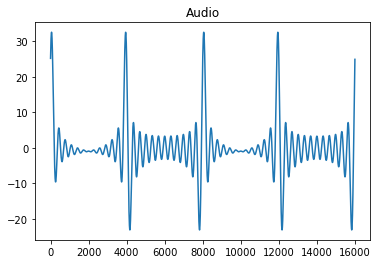

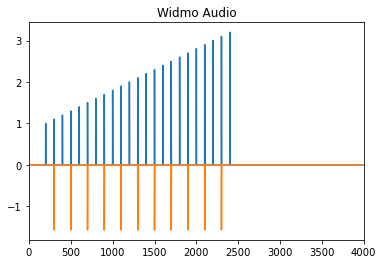

In [2]:
tseq = np.arange(sample*time)

def generate_ramp_sound():
    ampl = 1.0
    freq = 200
    step_freq = 100

    result = generate_cos(tseq,sample, freq, ampl=ampl)
    offset = -((np.pi) * 0.49999)
    #offset = 0
    for i in range(1,23):
        ampl = ampl + 0.1; freq = freq + step_freq
        if (i % 2) == 0:
            result = result + generate_cos(tseq,sample, freq, ampl=ampl)
        else:
            result = result + generate_cos(tseq,sample, freq, ampl=ampl, offset = offset)
        #offset = offset + 0.2
    return result
        
#generowanie sygnału wejściowego
audio = generate_ramp_sound()
#audio = generate_cos(tseq,sample, 1200)
#audio = butter_lowpass_filter(np.random.normal(0, 1, size=sample),2500,sample, 4)
#audio = load_from_file("dtmf.wav")

plt.plot(audio[:16000])
plt.title("Audio")
plt.show()
show_fft_with_phase("Widmo Audio",audio,sample,(0,4000))
ipd.Audio(resampl_sound(audio), rate=22050)

## 2. Modulator 1.
Modulator kwadraturowy niskiej częstotliwości

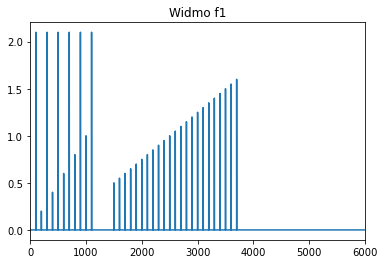

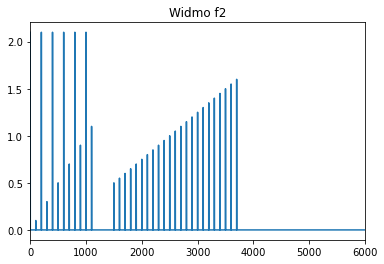

In [3]:
f0_freq = 1300
cos_f0 = generate_cos(tseq,sample, f0_freq)
sin_f0 = generate_sin(tseq,sample, f0_freq)

f1 = cos_f0 * audio
f2 = sin_f0 * audio

show_fft("Widmo f1",f1,sample,(0,6000))
show_fft("Widmo f2",f2,sample,(0,6000))


## 3. Filtr 1


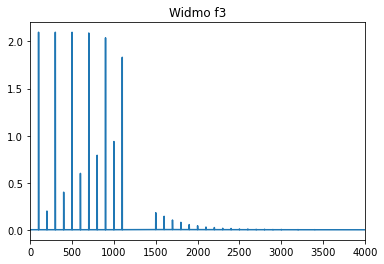

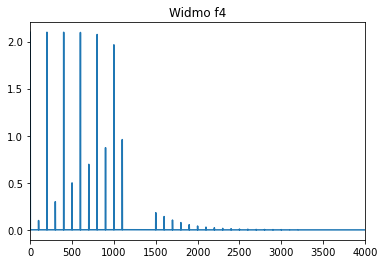

In [4]:
f3 = butter_lowpass_filter(f1,1400,sample, 4)
f4 = butter_lowpass_filter(f2,1400,sample, 4)

show_fft("Widmo f3",f3,sample,(0,4000))
show_fft("Widmo f4",f4,sample,(0,4000))


## 4. Testowe odtwarzanie sygnału po filtracji 

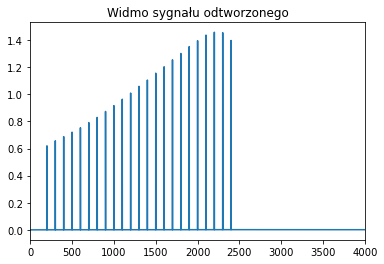

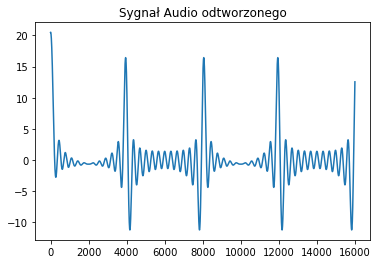

In [5]:
f1a = cos_f0 * f3
f2a = sin_f0 * f4
restory_audio = (f1a+f2a)
show_fft("Widmo sygnału odtworzonego",restory_audio,sample,(0,4000))

plt.plot(restory_audio[:16000])
plt.title("Sygnał Audio odtworzonego")
plt.show()

## 5. Modulator 2.

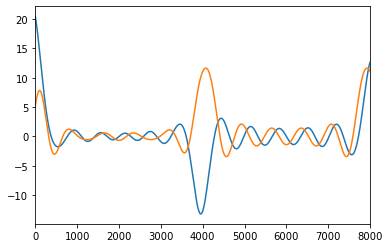

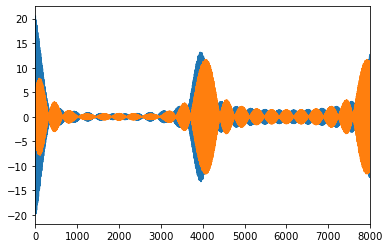

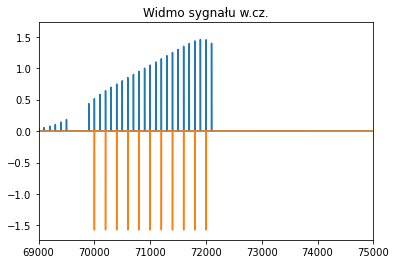

In [6]:
fs_freq = 71000
cos_fs = generate_cos(tseq,sample, fs_freq)
sin_fs = generate_sin(tseq,sample, fs_freq)

f5 = cos_fs * f3
f6 = sin_fs * f4

plt.plot(f3)
plt.plot(f4)
plt.xlim((0,8000))
plt.show()

plt.plot(f5)
plt.plot(f6)
plt.xlim((0,8000))
plt.show()

#fssb = f5 - f6 #lsb
fssb = f5 + f6  #usb
show_fft_with_phase("Widmo sygnału w.cz.",fssb,sample,(69000,75000))


## 6. Demodulator 1.

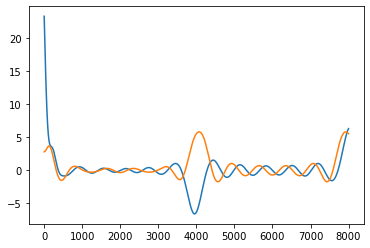

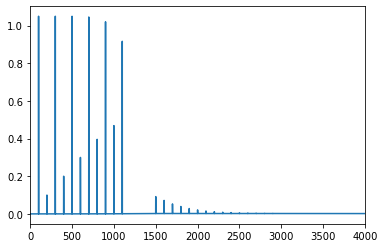

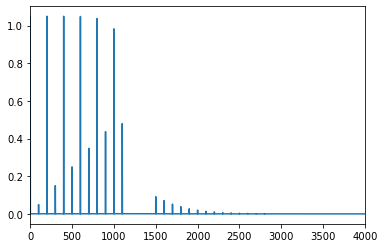

In [7]:
cos_fsd = generate_cos(tseq,sample, fs_freq)
sin_fsd = generate_sin(tseq,sample, fs_freq)


f7 = cos_fsd * fssb
#f8 = -sin_fs * fssb # lsb
f8 = sin_fsd * fssb # usb

f9 = butter_lowpass_filter(f7,3000,sample, 4)
f10 = butter_lowpass_filter(f8,3000,sample, 4)


plt.plot(f9[0:8000])
plt.plot(f10[0:8000])
plt.show()

show_fft("",f9,sample,(0,4000))
show_fft("",f10,sample,(0,4000))

## 7. Demodulator 2.

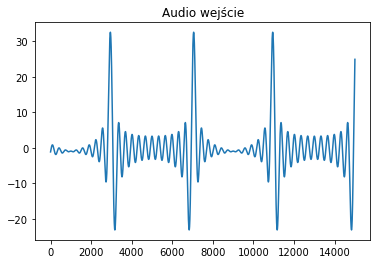

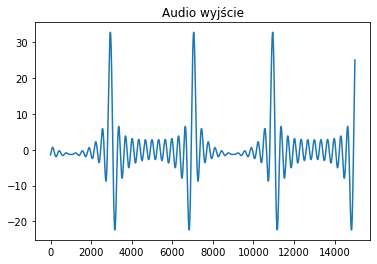

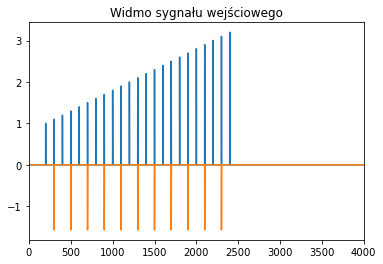

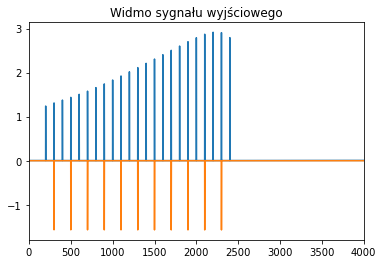

In [8]:
f0_freq = 1300
ph_offset = 0.0
cos_f0 = generate_cos(tseq,sample, f0_freq,offset = np.pi*2*ph_offset)
sin_f0 = generate_sin(tseq,sample, f0_freq, offset = np.pi*2*ph_offset)

f11 = cos_f0*f9
f12 = sin_f0*f10

audio_out = (f11 + f12) * 4.0

plt.plot(audio[1000:16000])
plt.title("Audio wejście")
plt.show()
plt.plot(audio_out[1000:16000])
plt.title("Audio wyjście")
plt.show()

show_fft_with_phase("Widmo sygnału wejściowego",audio,sample,(0,4000))
show_fft_with_phase("Widmo sygnału wyjściowego",audio_out,sample,(0,4000))
ipd.Audio(resampl_sound(audio_out), rate=22050)